# Tensorflow Expedia plus features

In [ ]:
!pip install tensorflow_recommenders
!pip install sklearn

In [80]:
import os
import pprint
import tempfile

from typing import Dict, Text

import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd

import tensorflow_recommenders as tfrs

In [81]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Load data

In [3]:
data_dir = '../data/expedia/'

def convert_date(date_col):
    return (pd.to_datetime(date_col) - dt.datetime(1970,1,1)).dt.total_seconds()

def convert_features(df: pd.DataFrame) -> pd.DataFrame:
    
    # Convert date to unix timestamp
    df['date_time'] = convert_date(df['date_time'])
    
    # Convert to bytes
    df['user_id'] = [bytes(str(uid), 'utf-8') for uid in df['user_id']]
    
    df = df.drop(['srch_ci', 'srch_co'], axis=1)
    
    if 'hotel_cluster' in df.columns:
        df['hotel_cluster'] = [bytes(str(uid), 'utf-8') for uid in df['hotel_cluster']]
        df = df.drop(['cnt'], axis=1)
    
    return df
    

def create_tf_datasets(df: pd.DataFrame):
            
    features = convert_features(df)
        
    # Create tf datasets
    dataset = tf.data.Dataset.from_tensor_slices((dict(features))) 
    hotels = tf.data.Dataset.from_tensor_slices([bytes(str(uid), 'utf-8') for uid in range(0, 99)])
    
    # Column selection
    dataset = dataset.map(lambda x: {
        "hotel_cluster": x["hotel_cluster"],
        "user_id": x["user_id"],
        "is_package" : x["is_package"],
    })
    
    return dataset, hotels, len(df)
    
def create_tf_test_dataset(df: pd.DataFrame):
    
    features = convert_features(df)
    
    dataset = tf.data.Dataset.from_tensor_slices((dict(features))) 

    return dataset.map(lambda x: {
        "user_id": x["user_id"],
        "is_package" : x["is_package"],
    })    

In [84]:
filename = 'train' # 'train_sample'

df = pd.read_csv(data_dir + f'{filename}.csv')

dataset, hotels, n_records = create_tf_datasets(df)

## Colab load data

### Manual upload

In [ ]:
# Upload Colab per file
from google.colab import files
import io

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
    
df = pd.read_csv(io.StringIO(uploaded['train_sample.csv'].decode('utf-8')))

### Load from Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

#changing the working directory
%cd /content/gdrive/My Drive/kaggle
#Check the present working directory using pwd command
pwd()

In [ ]:
# Download the Kaggle dataset in case
!kaggle competitions download -c expedia-hotel-recommendations
!unzip \*.zip  && rm *.zip

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
dataset, hotels, n_records = create_tf_datasets(df)

## Parse data

In [6]:
for x in dataset.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'hotel_cluster': b'15', 'is_package': 0, 'user_id': b'472333'}


In [7]:
user_ids = dataset.batch(1_000_000).map(lambda x: x["user_id"])
hotel_clusters = hotels.batch(1_000_000)

unique_user_ids = np.unique(np.concatenate(list(user_ids)))
unique_hotel_clusters = np.unique(np.concatenate(list(hotel_clusters)))

unique_hotel_clusters[:10]

array([b'0', b'1', b'10', b'11', b'12', b'13', b'14', b'15', b'16', b'17'],
      dtype=object)

In [8]:
is_package = np.concatenate(list(dataset.map(lambda x: x["is_package"]).batch(100)))

## Model

Indicator columns and embedding columns never work on features directly

https://keras.io/guides/preprocessing_layers/

In [9]:
class UserModel(tf.keras.Model):
  
    def __init__(self):
        super().__init__()

        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
        ])

        self.package_encoder = (tf.keras
                                .layers.experimental
                                .preprocessing
                                .CategoryEncoding(output_mode="binary"))
        
        self.package_encoder.adapt(is_package)


    def call(self, inputs):

        return tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.package_encoder(inputs["is_package"]),
        ], axis=1)

In [10]:
# Candidate tower
class HotelClusterModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        
        self.hotel_clusters = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
          vocabulary=unique_hotel_clusters, mask_token=None),
          tf.keras.layers.Embedding(len(unique_hotel_clusters) + 1, embedding_dimension)
        ])
        
    def call(self, hotel_cluster):
        return self.hotel_clusters(hotel_cluster) 


In [11]:
embedding_dimension = 32

# top K categorical accuracy: how often the true candidate is in the top K candidates for a given query.


In [12]:
class ExpediaModel(tfrs.Model):

    def __init__(self):
        super().__init__()
        self.hotel_cluster_model: tf.keras.Model = HotelClusterModel()
                    
        self.user_model: tf.keras.Model = tf.keras.Sequential([
          UserModel(),
          tf.keras.layers.Dense(32)
        ])
        
        metrics = tfrs.metrics.FactorizedTopK(
          candidates=hotels.batch(128).map(self.hotel_cluster_model)
        )

        self.task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
          metrics=metrics
        )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model({
            "user_id": features["user_id"],
            "is_package": features["is_package"],
        })
        # And pick out the movie features and pass them into the movie model,
        # getting embeddings back.
        positive_hotel_clusters = self.hotel_cluster_model(features['hotel_cluster'])

        # The task computes the loss and the metrics.
        return self.task(user_embeddings, positive_hotel_clusters)

In [13]:
model = ExpediaModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [14]:
# TODO timesplit
tf.random.set_seed(42)
shuffled = dataset.shuffle(n_records, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(int(0.9 * n_records))
test = shuffled.skip(int(0.9* n_records)).take(int(0.1 * n_records))

cached_train = train.batch(8192).cache()
cached_test = test.batch(4096).cache()

In [15]:
fitted_model = model.fit(cached_train, 
          validation_data=cached_test,
          validation_freq=1,
          epochs=2)

Epoch 1/2
55/55 [==============================] - 33s 604ms/step - factorized_top_k: 0.3815 - factorized_top_k/top_1_categorical_accuracy: 0.0147 - factorized_top_k/top_5_categorical_accuracy: 0.0905 - factorized_top_k/top_10_categorical_accuracy: 0.1668 - factorized_top_k/top_50_categorical_accuracy: 0.6354 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 72985.0392 - regularization_loss: 0.0000e+00 - total_loss: 72985.0392 - val_factorized_top_k: 0.4052 - val_factorized_top_k/top_1_categorical_accuracy: 0.0213 - val_factorized_top_k/top_5_categorical_accuracy: 0.1201 - val_factorized_top_k/top_10_categorical_accuracy: 0.2065 - val_factorized_top_k/top_50_categorical_accuracy: 0.6781 - val_factorized_top_k/top_100_categorical_accuracy: 1.0000 - val_loss: 5597.8857 - val_regularization_loss: 0.0000e+00 - val_total_loss: 5597.8857
Epoch 2/2
55/55 [==============================] - 24s 438ms/step - factorized_top_k: 0.6601 - factorized_top_k/top_1_categorical_accuracy: 0.

In [16]:
model.evaluate(cached_test, return_dict=True)

13/13 [==============================] - 1s 86ms/step - factorized_top_k: 0.3957 - factorized_top_k/top_1_categorical_accuracy: 0.0251 - factorized_top_k/top_5_categorical_accuracy: 0.1075 - factorized_top_k/top_10_categorical_accuracy: 0.1872 - factorized_top_k/top_50_categorical_accuracy: 0.6587 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 31579.8324 - regularization_loss: 0.0000e+00 - total_loss: 31579.8324


{'factorized_top_k': array([0.02512, 0.1075 , 0.18722, 0.6587 , 1.     ], dtype=float32),
 'factorized_top_k/top_1_categorical_accuracy': 0.025119999423623085,
 'factorized_top_k/top_5_categorical_accuracy': 0.10750000178813934,
 'factorized_top_k/top_10_categorical_accuracy': 0.1872200071811676,
 'factorized_top_k/top_50_categorical_accuracy': 0.6586999893188477,
 'factorized_top_k/top_100_categorical_accuracy': 1.0,
 'loss': 6080.1240234375,
 'regularization_loss': 0,
 'total_loss': 6080.1240234375}

Top-5 accuracy: 0.11.


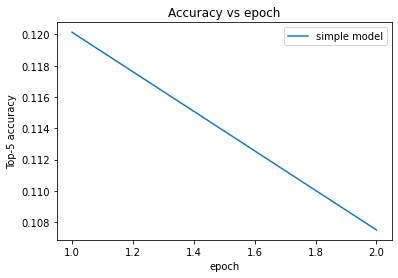

In [17]:
accuracy = fitted_model.history["val_factorized_top_k/top_5_categorical_accuracy"][-1]
print(f"Top-5 accuracy: {accuracy:.2f}.")

num_validation_runs = len(fitted_model.history["val_factorized_top_k/top_5_categorical_accuracy"])
epochs = [(x + 1)* 1 for x in range(num_validation_runs)]

plt.plot(epochs, fitted_model.history["val_factorized_top_k/top_5_categorical_accuracy"], label="simple model")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-5 accuracy");
plt.legend();

In [20]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [82]:
# Save model
query_path = os.path.join('./models/', f"{filename}_package_query_model")
model.user_model.save(query_path)

candidate_path = os.path.join('./models/', f"{filename}_package_candidate_model")
model.hotel_cluster_model.save(candidate_path)

In [ ]:
# Load model
filename = 'train_sample'
query_path = os.path.join('./models/', f"{filename}_package_query_model")
user_model = tf.keras.models.load_model(query_path)

candidate_path = os.path.join('./models/', f"{filename}_package_candidate_model")
candidate_model = tf.keras.models.load_model(candidate_path)
query_embedding = user_model(tf.constant(["10"]))

## Predictions

In [19]:
df = pd.read_csv(data_dir + 'test.csv')

In [20]:
final_test_set = create_tf_test_dataset(df)
final_test_set_cached = final_test_set.batch(4096)

In [21]:
cached_final_test_set = final_test_set.batch(8192).cache()

In [40]:
user_embeddings = model.user_model.predict(cached_final_test_set)

user_embeddings.shape

(2528243, 32)

### Brute Force

In [73]:
# Create a model that takes in raw query features, and
index_bruteforce = tfrs.layers.ann.BruteForce()

hotel_cluster_embeddings = hotels.batch(100).map(model.hotel_cluster_model)

# recommends hotels from all hotel clusters.
index_bruteforce.index(candidates=hotel_cluster_embeddings, 
                      identifiers=hotels)

brute_force_result = index_bruteforce(queries=user_embeddings)[1].numpy()

results = [[int(i)
 for i 
 in query[:5]]
 for query
 in brute_force_result
]

In [79]:
results

[[59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [80, 73, 44, 26, 89],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [43, 36, 93, 3, 81],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [80, 73, 44, 26, 89],
 [59, 93, 5, 43, 90],
 [80, 73, 44, 26, 89],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [89, 93, 60, 51, 15],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [59, 93, 5, 43, 90],
 [80, 73, 44, 26, 89],
 [13, 72, 4, 83, 40],
 [24,

## Archive

In [23]:
_, hotel_cluster = index(queries={'user_id':tf.constant(["472333"]), 
                                   'is_package': tf.constant([1])})
print(f"Recommendations for user 472333: {hotel_cluster[0, :3]}")

Consider rewriting this model with the Functional API.
Recommendations for user 472333: [b'15' b'10' b'76']


In [24]:
users_to_predict

,user_id,is_package
0,1,0
1,1,0
2,20,0
3,28,1
4,50,0
...,...,...
2528238,1198754,0
2528239,1198758,0
2528240,1198771,0
2528241,1198775,0


In [ ]:
results = []

for i, user in users_to_predict.iterrows():
    _, hotel_clusters = index(queries={'user_id':tf.constant([str(user['user_id'])]), 
                                       'is_package': tf.constant([user['is_package']])})
    results.append({'user_id': user['user_id'], 'hotel cluster' : [int(i) for i in hotel_clusters[0, :5].numpy()]})
    if i % 1_000 == 0:
        print(f"Parsed {i} users.")

In [38]:
pd.DataFrame(results)

,user_id,hotel cluster
0,1,"[5, 83, 90, 9, 6]"
1,1,"[5, 83, 90, 9, 6]"
2,20,"[5, 83, 90, 9, 6]"
3,28,"[80, 73, 87, 52, 0]"
4,50,"[5, 83, 90, 9, 6]"
...,...,...
995,3212,"[5, 83, 90, 9, 6]"
996,3220,"[5, 83, 90, 9, 6]"
997,3221,"[3, 30, 61, 53, 29]"
998,3221,"[3, 53, 61, 30, 20]"


### Brute force per record

Too slow and yields the same result

In [65]:
# Create a model that takes in raw query features, and
index_bruteforce = tfrs.layers.ann.BruteForce(query_model=model.user_model)

hotel_cluster_embeddings = hotels.batch(100).map(model.hotel_cluster_model)

# recommends hotels from all hotel clusters.
index_bruteforce.index(candidates=hotel_cluster_embeddings, 
                      identifiers=hotels)

results_bruteforce = []

for row in final_test_set.batch(1).take(5_00):
    _, hotel_cluster = index_bruteforce(queries=row)
    results_bruteforce.append([int(i) for i in hotel_cluster.numpy()[0][:5]])

### Annoy

Uses NNeirest neighbours for the items. Because we 'only' have 100 items (=hotel clusters), the computational benefit does not differ much from brute force.

In [ ]:
from annoy import AnnoyIndex

index = AnnoyIndex(embedding_dimension, "dot")

hotel_embeddings = hotels.enumerate().map(lambda idx, cluster: (idx, cluster, model.hotel_cluster_model(cluster)))
hotel_embeddings

# We unbatch the dataset because Annoy accepts only scalar (id, embedding) pairs.
for hotel_id, _, hotel_embedding in hotel_embeddings.as_numpy_iterator():
    index.add_item(hotel_id, hotel_embedding)

# Build a 10-tree ANN index.
index.build(10)

results = []

for i, row in enumerate(final_test_set.batch(1).take(len(final_test_set))):
    query_embedding = model.user_model(row)[0]
    results.append(index.get_nns_by_vector(query_embedding, 5))
    print(query_embedding)
    if i % 10_000 == 0:
        print(f"Parsed {i} users.")
        
# import pickle

# with open("./results_230_000.txt", "wb") as fp:   #Pickling
#     pickle.dump(results, fp)